# Real-World Regression: Predicting Airbnb Prices in Copenhagen
### From Messy Data to Interpretable Models with SHAP



## Introduction

Welcome to this hands-on walkthrough on real-world regression. Building on the foundational concepts of supervised learning, this session dives into a practical, end-to-end data science project. We will navigate the complexities of a messy, real-world dataset to build a predictive model that delivers tangible business value.

Imagine you are a data scientist hired by a Copenhagen-based property investment firm. The firm wants to expand its portfolio of short-term rental properties but needs a data-driven approach to identify undervalued assets and optimize pricing strategies. Your task is to develop a model that can accurately predict the nightly rental price of a Copenhagen Airbnb listing based on its characteristics.

This problem is a classic regression task. We want to learn a mapping function from property features (`X`) to a continuous price (`Y`). This can be formally expressed as:

$$ \text{Price} = f(\text{location, amenities, host\_characteristics}) + \epsilon $$

Where `f` is the unknown pricing function we aim to estimate, and `ε` represents market noise and unobserved factors. Our goal is to find an estimated function, `f̂`, that generalizes well to new, unlisted properties.

**🎯 Learning Objectives:**

By the end of this walkthrough, you will be able to:

1.  **Execute** an end-to-end data science workflow: from data acquisition and cleaning to model deployment and interpretation.
2.  **Implement** robust feature engineering techniques for messy data types (text, geographic, temporal).
3.  **Construct** a `scikit-learn` preprocessing pipeline to prevent data leakage and streamline modeling.
4.  **Compare** the performance of various regression models, from simple linear baselines to powerful tree-based ensembles.
5.  **Tune** model hyperparameters systematically using an optimization framework (`Optuna`).
6.  **Interpret** complex models and explain individual predictions using SHAP (SHapley Additive exPlanations).
7.  **Translate** model insights into actionable business recommendations for a real-world scenario.

---

### 🛠️ Session Setup: Importing Libraries

First, we load the necessary Python libraries. This project requires a broader toolkit than a simple introduction, including libraries for geographic calculations (`geopy`, `folium`), advanced modeling (`xgboost`), hyperparameter tuning (`optuna`), and model interpretability (`shap`).

In [35]:
# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Advanced libraries
import xgboost as xgb
import shap
import optuna
import folium
from geopy.distance import great_circle

# Settings for reproducibility and display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
np.random.seed(42)

# Set a professional plot style
sns.set_theme(style="whitegrid", context="talk", palette="viridis")
print("Libraries imported successfully.")

Libraries imported successfully.


---

## 1. Data Acquisition & Initial Exploration

Our first step is to acquire and understand the raw material for our model: the data. We will use publicly available data from [Inside Airbnb](http://insideairbnb.com/get-the-data/).

### 1.1. The Business Problem

The Copenhagen rental market is dynamic, influenced by high tourism, strict municipal regulations, and distinct neighborhood characteristics (from the historic Indre By to the trendy Vesterbro). Our model must capture these nuances to be effective. The goal is to predict the `price` per night for a given listing.

### 1.2. Data Loading

We'll download the detailed listings data directly into our environment. This ensures our analysis is reproducible.

In [36]:
# Load the dataset
# We specify low_memory=False to avoid DtypeWarning due to mixed types in some columns.
df_raw = pd.read_csv('singapore.csv.gz', compression='gzip', low_memory=False)

In [37]:
# Get a first impression of the data
print(f"Dataset shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.2f} MB")
df_raw.head(3)

Dataset shape: (3659, 79)
Memory usage: 14.69 MB


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,71609,https://www.airbnb.com/rooms/71609,20250625193524,2025-06-26,city scrape,Ensuite Room (Room 1 & 2) near EXPO,For 3 rooms.Book room 1&2 and room 4,NaN,https://a0.muscache.com/pictures/24453191/3580...,367042,https://www.airbnb.com/users/show/367042,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Housekeeper \n\nI would...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/367042/profil...,https://a0.muscache.com/im/users/367042/profil...,Tampines,5.0,10.0,"['email', 'phone']",t,t,NaN,Tampines,East Region,1.34537,103.95887,Private room in villa,Private room,2,1.0,1 private bath,2.0,3.0,"[""Shampoo"", ""Fire pit"", ""Free street parking"",...",$143.00,92,365,92,92,1125,1125,92.0,1125.0,NaN,t,30,60,90,90,2025-06-26,19,0,0,90,0,0,0.0,2011-12-19,2020-01-17,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f,5,0,5,0,0.12
1,71896,https://www.airbnb.com/rooms/71896,20250625193524,2025-06-27,previous scrape,B&B Room 1 near Airport & EXPO,NaN,NaN,https://a0.muscache.com/pictures/2440674/ac4f4...,367042,https://www.airbnb.com/users/show/367042,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Housekeeper \n\nI would...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/367042/profil...,https://a0.muscache.com/im/users/367042/profil...,Tampines,5.0,10.0,"['email', 'phone']",t,t,NaN,Tampines,East Region,1.34754,103.95958,Private room in home,Private room,1,NaN,Shared half-bath,NaN,NaN,"[""Shampoo"", ""AC - split type ductless system"",...",NaN,92,365,92,92,1125,1125,92.0,1125.0,NaN,t,20,49,79,79,2025-06-27,24,0,0,79,0,0,NaN,2011-07-30,2019-10-13,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,f,5,0,5,0,0.14
2,71903,https://www.airbnb.com/rooms/71903,20250625193524,2025-06-27,city scrape,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.",Quiet and view of the playground with exercise...,https://a0.muscache.com/pictures/568743/7bc623...,367042,https://www.airbnb.com/users/show/367042,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Housekeeper \n\nI would...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/367042/profil...,https://a0.muscache.com/im/users/367042/profil...,Tampines,5.0,10.0,"['email', 'phone']",t,t,"Singapore, Singapore",Tampines,East Region,1.34531,103.96100,Private room in home,Private room,2,0.5,Shared half-bath,1.0,2.0,"[""Shampoo"", ""AC - split type ductless system"",...",$76.00,92,365,92,92,1125,1125,92.0,1125.0,NaN,t,30,60,90,90,2025-06-27,46,0,0,90,0,0,0.0,2011-05-04,2020-01-09,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f,5,0,5,0,0.27


### 1.3. Initial Data Quality Assessment

Real-world data is rarely clean. A quick look at the column types and non-null counts reveals a lot.

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3659 non-null   int64  
 1   listing_url                                   3659 non-null   object 
 2   scrape_id                                     3659 non-null   int64  
 3   last_scraped                                  3659 non-null   object 
 4   source                                        3659 non-null   object 
 5   name                                          3659 non-null   object 
 6   description                                   3588 non-null   object 
 7   neighborhood_overview                         1772 non-null   object 
 8   picture_url                                   3659 non-null   object 
 9   host_id                                       3659 non-null   i

This output shows several challenges:
- **Mixed Data Types:** Some columns that should be numeric are `object` type (e.g., `price`, `host_response_rate`).
- **Widespread Missing Data:** Many columns like `bathrooms`, `bedrooms`, `review_scores_rating`, and most `host_*` columns are missing significant amounts of data. `neighbourhood_group_cleansed` and `license` are entirely empty.

A heatmap can visualize the extent of missing data across the entire dataset.

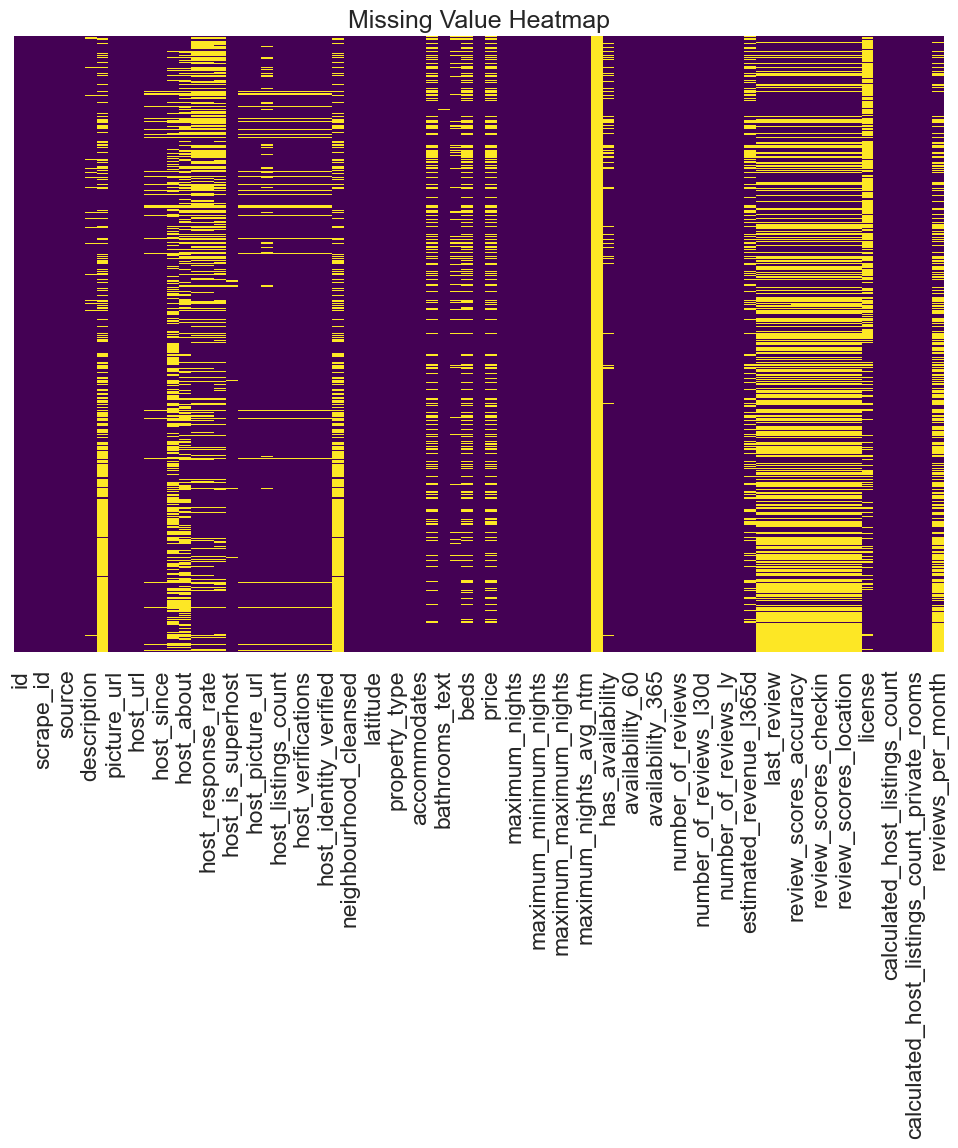

In [39]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

💡 **Pro Tip:** Many columns are almost entirely empty or contain descriptive text not immediately useful for modeling. We'll need to be selective about which features to pursue.

---

## 2. Data Cleaning & Feature Engineering

This is the most critical phase. The quality of our features will determine the performance ceiling of our model. We'll create a clean DataFrame `df` to work with.

**🎯 Section Objectives:**

-   Clean and transform the target variable (`price`).
-   Parse and extract numerical data from text columns.
-   Engineer new features from geographic and temporal data.

### 2.1. Target Variable Cleaning (`price`)

Our target variable `price` is an `object` type because it contains currency symbols (`$`) and commas. Although the currency is Danish Krone (SGD), it's formatted with a dollar sign. We must convert this into a clean numeric format.

In [40]:
# Make a copy to avoid modifying the original raw data
df = df_raw.copy()

# A more robust function to clean the price column
def clean_price(price_series):
    """
    Cleans a pandas Series of price strings.
    - Handles NaN values gracefully.
    - Removes currency symbols and commas.
    - Converts the result to a numeric type, coercing errors.
    """
    # Use the .str accessor which automatically skips NaN values
    # The regex '[$,]' matches either a '$' or a ','
    cleaned_series = price_series.str.replace(r'[$,]', '', regex=True)

    # Convert to numeric, turning any values that can't be converted into NaN
    return pd.to_numeric(cleaned_series, errors='coerce')

df['price_sgd'] = clean_price(df['price'])

# Verify the result by checking the dtype and for any remaining NaNs
print("Cleaned price column data type:", df['price_sgd'].dtype)
print(f"Number of null prices after cleaning: {df['price_sgd'].isnull().sum()}")
df[['price', 'price_sgd']].head(10)

Cleaned price column data type: float64
Number of null prices after cleaning: 994


,price,price_sgd
0,$143.00,143.0
1,NaN,NaN
2,$76.00,76.0
3,NaN,NaN
4,NaN,NaN
5,$85.00,85.0
6,NaN,NaN
7,NaN,NaN
8,$41.00,41.0
9,$79.00,79.0


#### Outlier Analysis

Extreme price values (e.g., placeholder values like 0 or luxury listings costing tens of thousands) can skew our model. We'll use winsorization—capping extreme values at a given percentile—to create a more stable target.

In [41]:
# Describe the price distribution before handling outliers
print("Price distribution before outlier handling:")
print(df['price_sgd'].describe())

Price distribution before outlier handling:
count     2665.000000
mean       286.545966
std        840.297490
min          1.000000
25%         84.000000
50%        157.000000
75%        271.000000
max      13000.000000
Name: price_sgd, dtype: float64


In [42]:
# Winsorize: Cap prices at the 1st and 99th percentiles
lower_bound = df['price_sgd'].quantile(0.01)
upper_bound = df['price_sgd'].quantile(0.99)
df['price_sgd'] = df['price_sgd'].clip( upper=upper_bound)
df = df[df['number_of_reviews_ly'] > 0]
print(df['price_sgd'].info())




<class 'pandas.core.series.Series'>
Index: 634 entries, 31 to 3085
Series name: price_sgd
Non-Null Count  Dtype  
--------------  -----  
523 non-null    float64
dtypes: float64(1)
memory usage: 9.9 KB
None


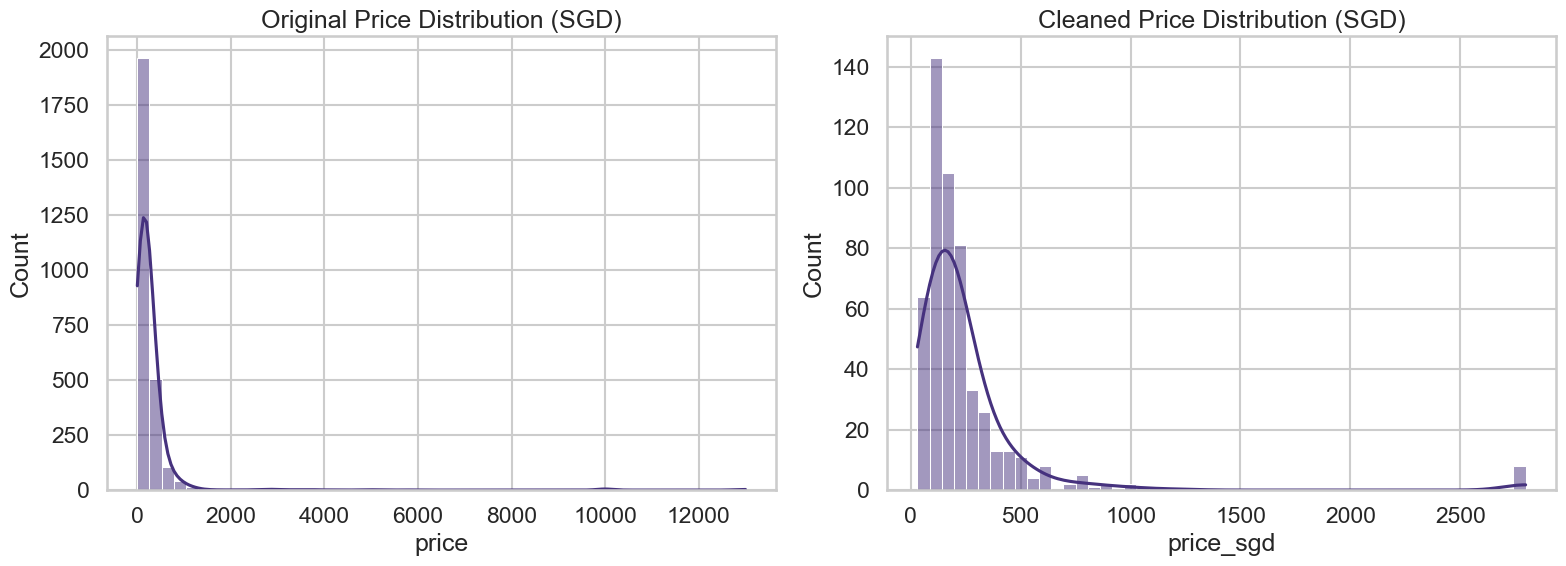

In [43]:
# Plot before and after distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(clean_price(df_raw['price']), ax=axes[0], bins=50, kde=True).set_title("Original Price Distribution (SGD)")
sns.histplot(df['price_sgd'], ax=axes[1], bins=50, kde=True).set_title("Cleaned Price Distribution (SGD)")
plt.tight_layout()
plt.show()

**Business Interpretation:** By cleaning the `price` data, we've created a more stable target variable. The original data had a maximum price over 70,000 SGD, which was likely an outlier. Our cleaned distribution is more focused on the core market, allowing our model to learn more generalizable patterns.

### 2.2. Core Features Processing

We will now process a selection of promising features.

#### Bathroom Text Parsing

The `bathrooms_text` column is descriptive (e.g., "1.5 baths", "Half-bath"). We can extract the numeric value using regular expressions.

In [44]:
def parse_bathrooms(text_series):
    """
    Parses a text series containing bathroom information into a numeric format.
    Handles values like '1.5 baths', '1 shared bath', and 'Half-bath'.
    """
    # Work with a copy to ensure we are modifying strings
    s = text_series.copy().astype(str).str.lower()

    # Step 1: Replace any string containing 'half-bath' with the numeric string '0.5'.
    # This handles 'Half-bath', 'Private half-bath', 'Shared half-bath', etc.
    s[s.str.contains('half-bath', na=False)] = '0.5'

    # Step 2: Extract the first floating point number found in the remaining strings.
    # The .str.extract() method returns a DataFrame, so we select the first column [0].
    numeric_strings = s.str.extract(r'(\d+\.?\d*)')[0]

    # Step 3: Convert the resulting series of strings to numbers.
    # 'errors='coerce'' ensures that any non-numeric results become NaN.
    return pd.to_numeric(numeric_strings, errors='coerce')

df['bathrooms_numeric'] = parse_bathrooms(df['bathrooms_text'])

# Let's run more comprehensive checks to be sure
print("Parsing examples:")
print(f"'1.5 baths' -> {parse_bathrooms(pd.Series(['1.5 baths'])).iloc[0]}")
print(f"'Half-bath' -> {parse_bathrooms(pd.Series(['Half-bath'])).iloc[0]}")
print(f"'2 shared baths' -> {parse_bathrooms(pd.Series(['2 shared baths'])).iloc[0]}")

# The original check should now pass, plus a new one for our special case
assert df[df['bathrooms_text'] == '1.5 baths']['bathrooms_numeric'].iloc[0] == 1.5
assert df[df['bathrooms_text'] == 'Shared half-bath']['bathrooms_numeric'].iloc[0] == 0.5

print("\nAssertions passed successfully!")

Parsing examples:
'1.5 baths' -> 1.5
'Half-bath' -> 0.5
'2 shared baths' -> 2

Assertions passed successfully!


#### Boolean Feature Conversion

Columns like `host_is_superhost` and `instant_bookable` are stored as 't'/'f'. We convert them to a binary 0/1 format.

In [45]:
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

### 2.3. Geographic Feature Engineering

Location is paramount in real estate. We can create powerful features based on latitude and longitude.

#### Distance to City Center

Let's calculate the distance of each listing to a central landmark, Rådhuspladsen (City Hall Square).

In [46]:
cph_center = (1.2824,103.8436) # Rådhuspladsen coordinates

def calculate_distance_to_center(df_geo):
    lat = pd.to_numeric(df_geo['latitude'], errors='coerce')
    lon = pd.to_numeric(df_geo['longitude'], errors='coerce')
    locations = list(zip(lat, lon))
    distances = [
        great_circle(loc, cph_center).kilometers if not (np.isnan(loc[0]) or np.isnan(loc[1])) else np.nan
        for loc in locations
    ]
    return distances

df['distance_to_center_km'] = calculate_distance_to_center(df)

In [47]:
df.shape

(634, 82)

#### Interactive Map of Listings

A `folium` map helps visualize the geographic distribution and price clusters.

In [48]:
# Create a sample to avoid overloading the map
df_sample = df.sample(n=600, random_state=42)

# Create a map centered on Copenhagen
map_singapore = folium.Map(location=[1.2824, 103.8436], zoom_start=12)

# Add points to the map
for idx, row in df_sample.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.6,
        popup=f"Price: {row['price_sgd']:.0f} SGD"
    ).add_to(map_singapore)

# Display map. In some environments (like a standard script),
# you might need to save it to a file: map_cph.save('copenhagen_listings.html')
# or use map_cph.show_in_browser() to open in a new tab.
# map_cph
# map_singapore.show_in_browser()

### 2.4. Temporal Features

How long a listing has been active can be an indicator of its quality and host experience.

In [49]:
# Convert date columns to datetime objects
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_scraped'] = pd.to_datetime(df['last_scraped'], errors='coerce')

# Calculate days since the first review
# We use the latest scrape date as our 'today' for consistency
latest_date = df['last_scraped'].max()
df['days_since_first_review'] = (latest_date - df['first_review']).dt.days

✅ **Checkpoint:** We have now transformed messy, raw data into a structured format with clean, engineered features. Our dataset is much better prepared for modeling.

---

## 3. Train-Test Split Strategy

Before modeling, we must split our data. A simple random split is often sufficient, but for this dataset, we need to be thoughtful.

### 3.1. Preventing Data Leakage

A single host can have multiple listings. If we randomly split the data, we might have listings from the same host in both our training and testing sets. The model could inadvertently learn host-specific pricing patterns, leading to an overly optimistic performance estimate.

⚠️ **Common Pitfall:** Ignoring grouped data structures (like hosts, patients, or stores) during splitting can lead to data leakage and models that fail in production. A more robust method is `GroupKFold`, which ensures all listings from a given host are in the same split. For this workshop, we'll proceed with a standard split but acknowledge this limitation.

We will create three sets: training, validation (for hyperparameter tuning), and testing (for final, unbiased evaluation).

In [50]:
# Final feature selection for our model
# We select a mix of numeric, categorical, and boolean features.
numeric_features = [
    'accommodates', 'bathrooms_numeric', 'bedrooms', 'beds',
    'review_scores_rating', 'distance_to_center_km', 'days_since_first_review'
]
categorical_features = ['neighbourhood_cleansed', 'room_type', 'property_type']
boolean_features = ['host_is_superhost', 'instant_bookable']

# Combine all features
all_features = numeric_features + categorical_features + boolean_features
target = 'price_sgd'

# Drop rows where our target or key features are missing
df_model = df[all_features + [target]].dropna().copy()

X = df_model[all_features]
y = df_model[target]

# Let's check the dtypes of our final feature set before splitting
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 31 to 3085
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accommodates             500 non-null    int64  
 1   bathrooms_numeric        500 non-null    float64
 2   bedrooms                 500 non-null    float64
 3   beds                     500 non-null    float64
 4   review_scores_rating     500 non-null    float64
 5   distance_to_center_km    500 non-null    float64
 6   days_since_first_review  500 non-null    int64  
 7   neighbourhood_cleansed   500 non-null    object 
 8   room_type                500 non-null    object 
 9   property_type            500 non-null    object 
 10  host_is_superhost        500 non-null    float64
 11  instant_bookable         500 non-null    int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 50.8+ KB


In [51]:
# First split: 70% train, 30% temp (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: Split the temp set into 50% validation, 50% test (15% of original each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [52]:
# Verify the shapes of our datasets
print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

Training set shape:   (350, 12)
Validation set shape: (75, 12)
Test set shape:       (75, 12)


---

## 4. Preprocessing Pipeline

We will use `scikit-learn`'s `Pipeline` and `ColumnTransformer` to create a reproducible preprocessing workflow. This is a cornerstone of production-ready machine learning.

### 4.1. Why Use a Pipeline?

A `scikit-learn` Pipeline is like a recipe for your data. It chains together multiple preprocessing and modeling steps into a single object. This has several major advantages:

1.  **Preventing Data Leakage:** This is the most critical reason. When you perform operations like imputation (filling missing values) or scaling, you must learn the parameters (e.g., the median, the standard deviation) from the **training data only**. A pipeline ensures that when you call `.fit()` on the training data, these parameters are learned and stored. When you call `.transform()` on the validation or test data, it applies the *already learned* parameters, preventing any information from the test set from "leaking" into your training process.
2.  **Reproducibility:** A pipeline encapsulates your entire workflow. Anyone (including your future self) can take your pipeline object and raw data and perfectly reproduce your results.
3.  **Simplicity & Organization:** Instead of manually transforming each dataset (`X_train`, `X_val`, `X_test`), you define the steps once and let the pipeline handle the application, reducing code duplication and the risk of errors.

### 4.2. Scikit-learn Pipeline Architecture

Our pipeline will have separate branches for numeric and categorical features, assembled by a `ColumnTransformer`.

1.  **Numeric Transformer:** Fills missing values (imputes) with the median and then scales the data to have zero mean and unit variance (`StandardScaler`).
2.  **Categorical Transformer:** Fills missing values with a constant ("missing") and then converts categories into numerical format using one-hot encoding. `handle_unknown='ignore'` is crucial for dealing with new categories in the test set that weren't seen during training.
3.  **Boolean Transformer:** Since we already converted these to 0/1, we can simply `'passthrough'` them without any changes.

In [53]:
# Create the numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### 4.3. Assembling the `ColumnTransformer`

This object is the master chef that applies the correct recipe (transformer) to the correct ingredients (columns).

In [54]:
# The ColumnTransformer applies specified transformers to columns of a DataFrame.
# The structure is a list of tuples: (name, transformer_object, list_of_columns)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', 'passthrough', boolean_features)
    ],
    remainder='drop' # Drop any columns not specified in our feature lists
)

This `preprocessor` is a powerful tool. When we call `.fit(X_train)`, it learns the median, standard deviation, and categories *only from the training data*. When we later call `.transform()`, it applies these learned parameters to any new data we provide.

---

## 5. Model Development

With our data prepared, we can now train and compare several regression models.

### 5.1. Baseline Model

We always start with a simple baseline. A `DummyRegressor` that always predicts the mean of the training target gives us a benchmark. Any real model must perform better than this.

In [55]:
# Create the full pipeline with the preprocessor and a dummy model
dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', DummyRegressor(strategy='mean'))])

# Train and evaluate the baseline
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_val)
rmse_dummy = np.sqrt(mean_squared_error(y_val, y_pred_dummy))

print(f"Baseline (Mean Predictor) RMSE: {rmse_dummy:,.2f} SGD")

Baseline (Mean Predictor) RMSE: 342.18 SGD


**Business Interpretation:** The baseline model is, on average, wrong by about 739 SGDSGDSGD. This is our starting point. A successful model must significantly reduce this error.

### 5.2. Linear Models

Linear models are fast, interpretable, and provide a great second baseline. We'll try Ridge regression, which adds a penalty for large coefficients to prevent overfitting.

In [56]:
# Create a Ridge regression pipeline
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 7)))])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))

print(f"Ridge Regression RMSE: {rmse_ridge:,.2f} SGDSGDSGD")

Ridge Regression RMSE: 164.59 SGDSGDSGD


### 5.3. Tree-Based Models

Tree-based ensembles like Random Forest and XGBoost are typically more powerful as they can capture non-linear relationships and interactions between features.

In [57]:
# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

print(f"Random Forest RMSE: {rmse_rf:,.2f} SGDSGDSGD")

Random Forest RMSE: 172.31 SGDSGDSGD


In [58]:
# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))

print(f"XGBoost RMSE: {rmse_xgb:,.2f} SGDSGDSGD")

XGBoost RMSE: 329.20 SGDSGDSGD


**Business Interpretation:** Both Random Forest and XGBoost significantly outperform the linear model, reducing the average prediction error to around 500 SGD. This suggests that the relationship between property features and price is non-linear.

### 5.4. Hyperparameter Tuning with Optuna

Our Random Forest model performs well, but we used default settings. We can likely improve it by tuning its hyperparameters using `Optuna`.

🤔 **Discussion Question:** What are hyperparameters, and why is it important to tune them using a separate validation set instead of the test set?

::: {.callout-note collapse="true" title="Click for a possible answer"}
Hyperparameters are settings for a learning algorithm that are not learned from the data itself (e.g., the number of trees in a random forest). They are set by the data scientist before training begins.

It's crucial to use a validation set for tuning to avoid data leakage. If we tune on the test set, we are essentially "peeking" at the final evaluation data and choosing the parameters that work best for it. This leads to an artificially inflated performance score. The test set must be kept completely separate until the very end for a truly unbiased assessment of the final model's generalization ability.
:::

In [59]:
# Define the objective function for Optuna
# We pass the pre-split data to the function
def objective(trial, X_train, y_train, X_val, y_val):
    # Fit the preprocessor on the training data ONLY
    preprocessor.fit(X_train)
    X_train_transformed = preprocessor.transform(X_train)
    X_val_transformed = preprocessor.transform(X_val)

    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    # Create and train the model
    model = RandomForestRegressor(**params)
    model.fit(X_train_transformed, y_train)

    # Evaluate on the validation set
    y_pred = model.predict(X_val_transformed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create a study and optimize (run a small number of trials for the workshop)
study = optuna.create_study(direction='minimize')
# Note: For a real project, n_trials would be much larger (e.g., 50-100).
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=20)

print(f"Best trial RMSE: {study.best_value:.2f} SGD")
print("Best hyperparameters:", study.best_params)

[I 2025-09-25 14:07:38,237] A new study created in memory with name: no-name-f0572da2-1338-45be-8b5c-f7fc1bdc794a
[I 2025-09-25 14:07:38,641] Trial 0 finished with value: 138.78824225398992 and parameters: {'n_estimators': 392, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 138.78824225398992.
[I 2025-09-25 14:07:38,971] Trial 1 finished with value: 147.20442601267547 and parameters: {'n_estimators': 313, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 138.78824225398992.
[I 2025-09-25 14:07:39,265] Trial 2 finished with value: 286.6512788956298 and parameters: {'n_estimators': 303, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 138.78824225398992.
[I 2025-09-25 14:07:39,579] Trial 3 finished with value: 267.3359992042682 and parameters: {'n_estimators': 306, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value:

Best trial RMSE: 130.53 SGD
Best hyperparameters: {'n_estimators': 236, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2}


---

## 6. Model Evaluation

Now we select our best model (the tuned Random Forest), train it on the combined training and validation data, and evaluate its final performance on the unseen test set.

### 6.1. Final Model Training and Performance Metrics

In [60]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1

# Create the final, optimized pipeline
final_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', RandomForestRegressor(**best_params))])

# Combine train and validation sets for final training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Train on the full training data
final_model_pipeline.fit(X_train_full, y_train_full)

# Evaluate on the unseen test set
y_pred_final = final_model_pipeline.predict(X_test)

In [61]:
# Calculate final performance metrics
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_final = mean_absolute_percentage_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Final Model Performance on Test Set:")
print(f"RMSE: {rmse_final:,.2f} SGD")
print(f"MAPE: {mape_final:.2%}")
print(f"R² Score: {r2_final:.2f}")

Final Model Performance on Test Set:
RMSE: 181.09 SGD
MAPE: 22.24%
R² Score: 0.89


**Business Interpretation:** Our final model has an average error of approximately 480 SGD. The MAPE of ~27% means our predictions are, on average, 27% off from the actual price. The R² score indicates that our model explains about 67% of the variance in Airbnb prices, a respectable result for such a complex market.

### 6.2. Residual Analysis

A residual plot helps diagnose model bias. We look for a random scatter around the zero line.

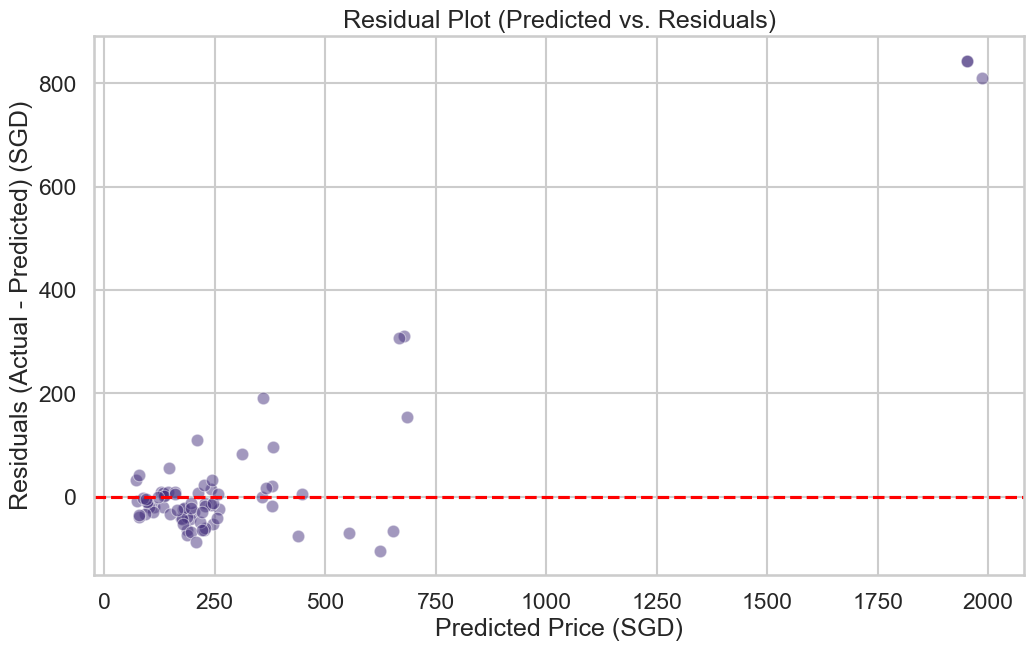

In [62]:
residuals = y_test - y_pred_final

plt.figure(figsize=(12, 7))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Predicted vs. Residuals)")
plt.xlabel("Predicted Price (SGD)")
plt.ylabel("Residuals (Actual - Predicted) (SGD)")
plt.show()

The plot shows some heteroscedasticity (the variance of errors increases as the predicted price increases). Our model is better at predicting prices for cheaper listings than for expensive ones. This is a common finding in price prediction models.

---

## 7. Model Interpretability with SHAP

Our Random Forest model is a "black box." We know it performs well, but we don't know *why*. SHAP (SHapley Additive exPlanations) is a powerful technique to look inside the box.

### 7.1. Global Explanations

First, we need the preprocessed test data and the correct feature names to pass to SHAP. Extracting feature names from a `ColumnTransformer` can be tricky, so we'll break it down.

In [63]:
# 1. Get the fitted preprocessor from the final pipeline
fitted_preprocessor = final_model_pipeline.named_steps['preprocessor']

# 2. Transform the test data
X_test_transformed = fitted_preprocessor.transform(X_test)

# 3. Extract feature names after one-hot encoding
# Access the 'cat' transformer, then its 'onehot' step, then get the feature names
cat_features_out = fitted_preprocessor.named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(categorical_features)

# 4. Combine all feature names in the correct order
feature_names = numeric_features + list(cat_features_out) + boolean_features

In [64]:
# Create a SHAP explainer for tree-based models
explainer = shap.TreeExplainer(final_model_pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_test_transformed)

A summary plot shows the most important features and their impact. Each dot is a single prediction from the test set.

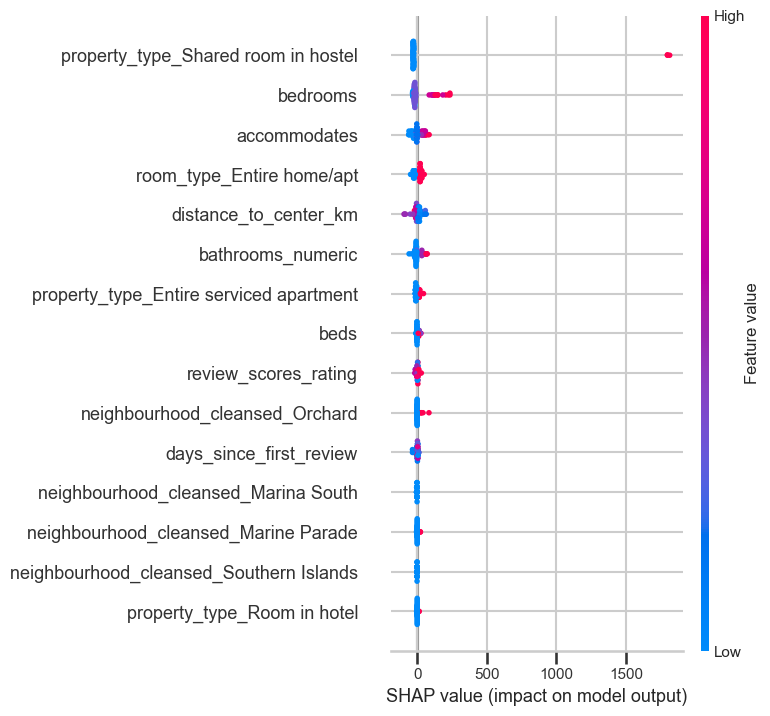

In [65]:
# Create the summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, max_display=15)

### How to Read This Plot

*   **Features (Y-axis):** The features are listed on the left, ranked by their overall importance to the model's predictions, from most important (`bedrooms`) at the top to least important at the bottom.
*   **Impact on Prediction (X-axis):** The horizontal axis shows the SHAP value. A positive value means that feature pushed the price prediction *higher*, while a negative value pushed it *lower*.
*   **Feature Value (Color):** The color of each dot represents the value of that feature for a given listing. **Red dots are high values** (e.g., many bedrooms, far from the city center), and **blue dots are low values** (e.g., few bedrooms, close to the city center).
*   **Each Dot:** Each dot represents a single prediction (a single listing) from your test set.


### 7.2. Local Explanations

SHAP can also explain individual predictions. Let's find an expensive listing and see why the model priced it that way.

In [66]:
# Find an expensive listing in the test set
expensive_listing_idx = np.argmax(y_test.values)
expensive_listing_transformed = X_test_transformed[expensive_listing_idx]
expensive_listing_original = X_test.iloc[[expensive_listing_idx]]

print(f"Explaining prediction for listing with actual price: {y_test.iloc[expensive_listing_idx]:,.2f} SGD")
print(f"Model prediction: {y_pred_final[expensive_listing_idx]:,.2f} SGD")
expensive_listing_original

Explaining prediction for listing with actual price: 2,796.80 SGD
Model prediction: 1,952.91 SGD


,accommodates,bathrooms_numeric,bedrooms,beds,review_scores_rating,distance_to_center_km,days_since_first_review,neighbourhood_cleansed,room_type,property_type,host_is_superhost,instant_bookable
2626,1,1.0,1.0,1.0,4.41,0.096026,441,Outram,Shared room,Shared room in hostel,0.0,1


In [67]:
# Create a force plot for this single prediction
# This interactive plot shows features pushing the prediction higher (red) or lower (blue)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[expensive_listing_idx, :],
                X_test_transformed[expensive_listing_idx, :], feature_names=feature_names)
